# COVID-Net CT Inference and Grad-CAM
This notebook provides some basic inference and visualization code for COVID-Net CT models. In particular, it includes example code for:
1. Loading and preprocessing images
2. Running inference on single images
3. Computing and displaying Grad-CAM visualizations of the predicitions

## Initial setup
COVID-Net CT models can be downloaded automatically by selecting the appropriate model name. The model will be downloaded from its location on Google Drive using gdown, and will be placed in the `/kaggle/working` directory

In [1]:
# Model name
MODEL_NAME = 'COVID-Net CT-2 S'

# Model location
MODEL_DIR = '/kaggle/working'
META_NAME = 'model.meta'
CKPT_NAME = 'model'

# Model IDs in Google Drive
MODEL_IDS = {
    'COVID-Net CT-2 L': (
        '1YQxVRYJ37nPSCtjUU9WWlXWRWYvZkKPl',
        '1EgelTN_fyku2m2fALqpJvfjkuQ7Wqqdg',
        '12BhWk_KiQ-hX--Qb7ASdPQTUOfOPccQE'),
    'COVID-Net CT-2 S': (
        '1zKTSxAhRrFhJxUnCcAf73WEZ7OcqvMre',
        '1CSYekjpU1qYXxuOkjL0fBuzBIkvFXAqw',
        '12uiQc5QePuqg2ErRF8llrL1vD9aFIiiJ')
}

# Data location
IMAGE_DIR = '/kaggle/input/covidxct/2A_images'
LABEL_FILE = '/kaggle/input/covidxct/val_COVIDx_CT-2A.txt'

# Tensor names
IMAGE_INPUT_TENSOR = 'Placeholder:0'
TRAINING_PH_TENSOR = 'is_training:0'
FINAL_CONV_TENSOR = 'resnet_model/block_layer4:0'
CLASS_PRED_TENSOR = 'ArgMax:0'
CLASS_PROB_TENSOR = 'softmax_tensor:0'
LOGITS_TENSOR = 'resnet_model/final_dense:0'

# Class names, in order of index
CLASS_NAMES = ('Normal', 'Pneumonia', 'COVID-19')

In [2]:
!pip install tensorflow==1.15

!pip install gdown
!gdown --id {MODEL_IDS[MODEL_NAME][0]}
!gdown --id {MODEL_IDS[MODEL_NAME][1]}
!gdown --id {MODEL_IDS[MODEL_NAME][2]}

     |████████████████████████████████| 412.3 MB 15 kB/s s eta 0:00:01  |▌                               | 6.9 MB 9.0 MB/s eta 0:00:46     |██                              | 26.4 MB 22.7 MB/s eta 0:00:17     |█████████                       | 115.5 MB 52.0 MB/s eta 0:00:06     |██████████                      | 128.8 MB 52.0 MB/s eta 0:00:06/s eta 0:00:04     |████████████████████            | 256.5 MB 73.7 MB/s eta 0:00:03     |███████████████████████         | 296.0 MB 73.7 MB/s eta 0:00:02     |██████████████████████████      | 335.4 MB 42.1 MB/s eta 0:00:02     |████████████████████████████▌   | 366.6 MB 66.1 MB/s eta 0:00:01     |██████████████████████████████▋ | 395.0 MB 66.1 MB/s eta 0:00:01
     |████████████████████████████████| 503 kB 26.8 MB/s eta 0:00:01
     |████████████████████████████████| 3.8 MB 53.1 MB/s eta 0:00:01
     |████████████████████████████████| 50 kB 5.6 MB/s  eta 0:00:01
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7538 sha256=8a8fd4

In [3]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

## Useful functions
The functions below provide model loading, data loading and preprocessing, Grad-CAM, and inference capabilities.

In [4]:
def create_session():
    """Helper function for session creation"""
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    sess = tf.Session(config=config)
    return sess

def load_graph(meta_file):
    """Creates new graph and session"""
    graph = tf.Graph()
    with graph.as_default():
        # Create session and load model
        sess = create_session()

        # Load meta file
        print('Loading meta graph from ' + meta_file)
        saver = tf.train.import_meta_graph(meta_file, clear_devices=True)
    return graph, sess, saver

def load_ckpt(ckpt, sess, saver):
    """Helper for loading weights"""
    # Load weights
    if ckpt is not None:
        print('Loading weights from ' + ckpt)
        saver.restore(sess, ckpt)

def load_labels(label_file):
    """Loads image filenames, classes, and bounding boxes"""
    fnames, classes, bboxes = [], [], []
    with open(label_file, 'r') as f:
        for line in f.readlines():
            fname, cls, xmin, ymin, xmax, ymax = line.strip('\n').split()
            fnames.append(fname)
            classes.append(int(cls))
            bboxes.append((int(xmin), int(ymin), int(xmax), int(ymax)))
    return fnames, classes, bboxes

def load_and_preprocess(image_file, bbox=None, width=512, height=512):
    """Loads and preprocesses images for inference"""
    # Load and crop image
    image = cv2.imread(image_file, cv2.IMREAD_GRAYSCALE)
    if bbox is not None:
        image = image[bbox[1]:bbox[3], bbox[0]:bbox[2]]
    image = cv2.resize(image, (width, height), cv2.INTER_CUBIC)

    # Convert to float in range [0, 1] and stack to 3-channel
    image = image.astype(np.float32) / 255.0
    image = np.expand_dims(np.stack((image, image, image), axis=-1), axis=0)
    
    return image


def make_gradcam_graph(graph):
    """Adds additional ops to the given graph for Grad-CAM"""
    with graph.as_default():
        # Get required tensors
        final_conv = graph.get_tensor_by_name(FINAL_CONV_TENSOR)
        logits = graph.get_tensor_by_name(LOGITS_TENSOR)
        preds = graph.get_tensor_by_name(CLASS_PRED_TENSOR)

        # Get gradient
        top_class_logits = logits[0, preds[0]]
        grads = tf.gradients(top_class_logits, final_conv)[0]

        # Comute per-channel average gradient
        pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
        
    return final_conv, pooled_grads
    

def run_gradcam(final_conv, pooled_grads, sess, image):
    """Creates a Grad-CAM heatmap"""
    with graph.as_default():
        # Run model to compute activations, gradients, predictions, and confidences
        final_conv_out, pooled_grads_out, class_pred, class_prob = sess.run(
            [final_conv, pooled_grads, CLASS_PRED_TENSOR, CLASS_PROB_TENSOR],
            feed_dict={IMAGE_INPUT_TENSOR: image, TRAINING_PH_TENSOR: False})
        final_conv_out = final_conv_out[0]
        class_pred = class_pred[0]
        class_prob = class_prob[0, class_pred]
        
        # Compute heatmap as gradient-weighted mean of activations
        for i in range(pooled_grads_out.shape[0]):
            final_conv_out[..., i] *= pooled_grads_out[i]
        heatmap = np.mean(final_conv_out, axis=-1)

        # Convert to [0, 1] range
        heatmap = np.maximum(heatmap, 0)/np.max(heatmap)
        
        # Resize to image dimensions
        heatmap = cv2.resize(heatmap, (image.shape[2], image.shape[1]))
        
    return heatmap, class_pred, class_prob

    
def run_inference(graph, sess, images, batch_size=1):
    """Runs inference on one or more images"""
    # Create feed dict
    feed_dict = {TRAINING_PH_TENSOR: False}

    # Run inference
    with graph.as_default():
        classes, confidences = [], []
        num_batches = int(np.ceil(images.shape[0]/batch_size))
        for i in range(num_batches):
            # Get batch and add it to the feed dict
            feed_dict[IMAGE_INPUT_TENSOR] = images[i*batch_size:(i + 1)*batch_size, ...]

            # Run images through model
            preds, probs = sess.run([CLASS_PRED_TENSOR, CLASS_PROB_TENSOR], feed_dict=feed_dict)

            # Add results to list
            classes.append(preds)
            confidences.append(probs)

    classes = np.concatenate(classes, axis=0)
    confidences = np.concatenate(confidences, axis=0)

    return classes, confidences


def stacked_bar(ax, probs):
    """Creates a stacked bar graph of slice-wise predictions"""
    x = list(range(probs.shape[0]))
    width = 0.8
    ax.bar(x, probs[:, 0], width, color='g')
    ax.bar(x, probs[:, 1], width, bottom=probs[:, 0], color='r')
    ax.bar(x, probs[:, 2], width, bottom=probs[:, :2].sum(axis=1), color='b')
    ax.set_ylabel('Confidence')
    ax.set_xlabel('Slice Index')
    ax.set_title('Class Confidences by Slice')
    ax.legend(CLASS_NAMES, loc='upper right')

## Loading the model and checkpoint
This cell loads the graph and checkpoint, and also adds additional ops for producing Grad-CAM visualizations.

In [5]:
# Create full paths
meta_file = os.path.join(MODEL_DIR, META_NAME)
ckpt = os.path.join(MODEL_DIR, CKPT_NAME)

# Load metagraph and create session
graph, sess, saver = load_graph(meta_file)

# Load checkpoint
with graph.as_default():
    load_ckpt(ckpt, sess, saver)
final_conv, pooled_grads = make_gradcam_graph(graph)

Loading meta graph from /kaggle/working/model.meta
Loading weights from /kaggle/working/model


## Inference with Grad-CAM
The image files may be set to any images you wish to test. Grad-CAM heatmaps will be computed for the predicted class to show which regions are being leveraged by the model during inference.

In [6]:
# Select image file
idx = 22585
filenames, classes, bboxes = load_labels(LABEL_FILE)
image_file = os.path.join(IMAGE_DIR, filenames[idx])
cls = classes[idx]
bbox = bboxes[idx]

**DISCLAIMER**
Do not use this prediction for self-diagnosis. You should check with your local authorities for the latest advice on seeking medical assistance.


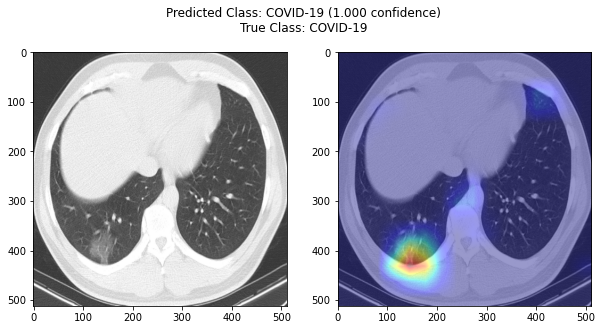

In [7]:
# Prepare image
image = load_and_preprocess(image_file, bbox)

# Run Grad-CAM
heatmap, class_pred, class_prob = run_gradcam(
    final_conv, pooled_grads, sess, image)

# Show image
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
plt.subplots_adjust(hspace=0.01)
ax[0].imshow(image[0])
plt.suptitle('Predicted Class: {} ({:.3f} confidence)\nTrue Class: {}'.format(CLASS_NAMES[class_pred], class_prob, CLASS_NAMES[cls]))
ax[1].imshow(image[0])
ax[1].imshow(heatmap, cmap='jet', alpha=0.4)

print('**DISCLAIMER**')
print('Do not use this prediction for self-diagnosis. '
      'You should check with your local authorities for '
      'the latest advice on seeking medical assistance.')
plt.show()